<a href="https://colab.research.google.com/github/AnikaZN/DS-Unit-2-Tree-Ensembles/blob/master/Tazmania_Work_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Module 1, Decision Trees**

In [1]:
! pip install category_encoders

import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


     |████████████████████████████████| 92kB 3.5MB/s 


In [2]:
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'
source = WEB

train = pd.merge(pd.read_csv(source + 'train_features.csv'), 
                 pd.read_csv(source + 'train_labels.csv'))

test = pd.read_csv(source + 'test_features.csv')

sample_submission = pd.read_csv(source + 'sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
def clean(X):
  
  X = X.copy()
  
  #small values are likely outside Tanzania, replace them with zero
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
  
  #replace unnecessary zeroes with column mean
  zero_cols = ['construction_year', 'longitude', 'latitude']
  for column in zero_cols:
    X[column] = X[column].replace(0, np.nan)
    X[column] = X[column].fillna(X[column].mean())
    
  #convert to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
  
  #extract year
  X['year_recorded'] = X['date_recorded'].dt.year
  
  #drop duplicate feature
  #X = X.drop(columns='quantity_group')
  
  #replace missing values with MISSING
  categoricals = X.select_dtypes(exclude='number').columns
  for col in categoricals:
    X[col] = X[col].fillna('MISSING')
    
  return X

train = clean(train)
val = clean(val)
test = clean(test)

In [0]:
#isolate features

target = 'status_group'



train_features = train.drop(columns=[target, 'id'])

numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 30].index.tolist()

features = categorical_features + numeric_features

In [0]:
#x features matrix and y target vector
x_train = train[features]
y_train = train[target]
x_val = val[features]
y_val = val[target]

x_test = test[features]

In [0]:
#encode
encoder = ce.OneHotEncoder(use_cat_names=True)
x_train_encoded = encoder.fit_transform(x_train)
x_val_encoded = encoder.transform(x_val)
x_test_encoded = encoder.transform(x_test)

In [0]:
#scale
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_encoded)
x_val_scaled = scaler.transform(x_val_encoded)
x_test_scaled = scaler.transform(x_test_encoded)

In [8]:
#model
model = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
model.fit(x_train_scaled, y_train)
print('Validation Accuracy', model.score(x_val_scaled, y_val))
y_pred = model.predict(x_test_scaled)

Validation Accuracy 0.736026936026936


In [0]:
#submission file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('anika-submission-01.csv', index=False)

from google.colab import files
files.download('anika-submission-01.csv') 

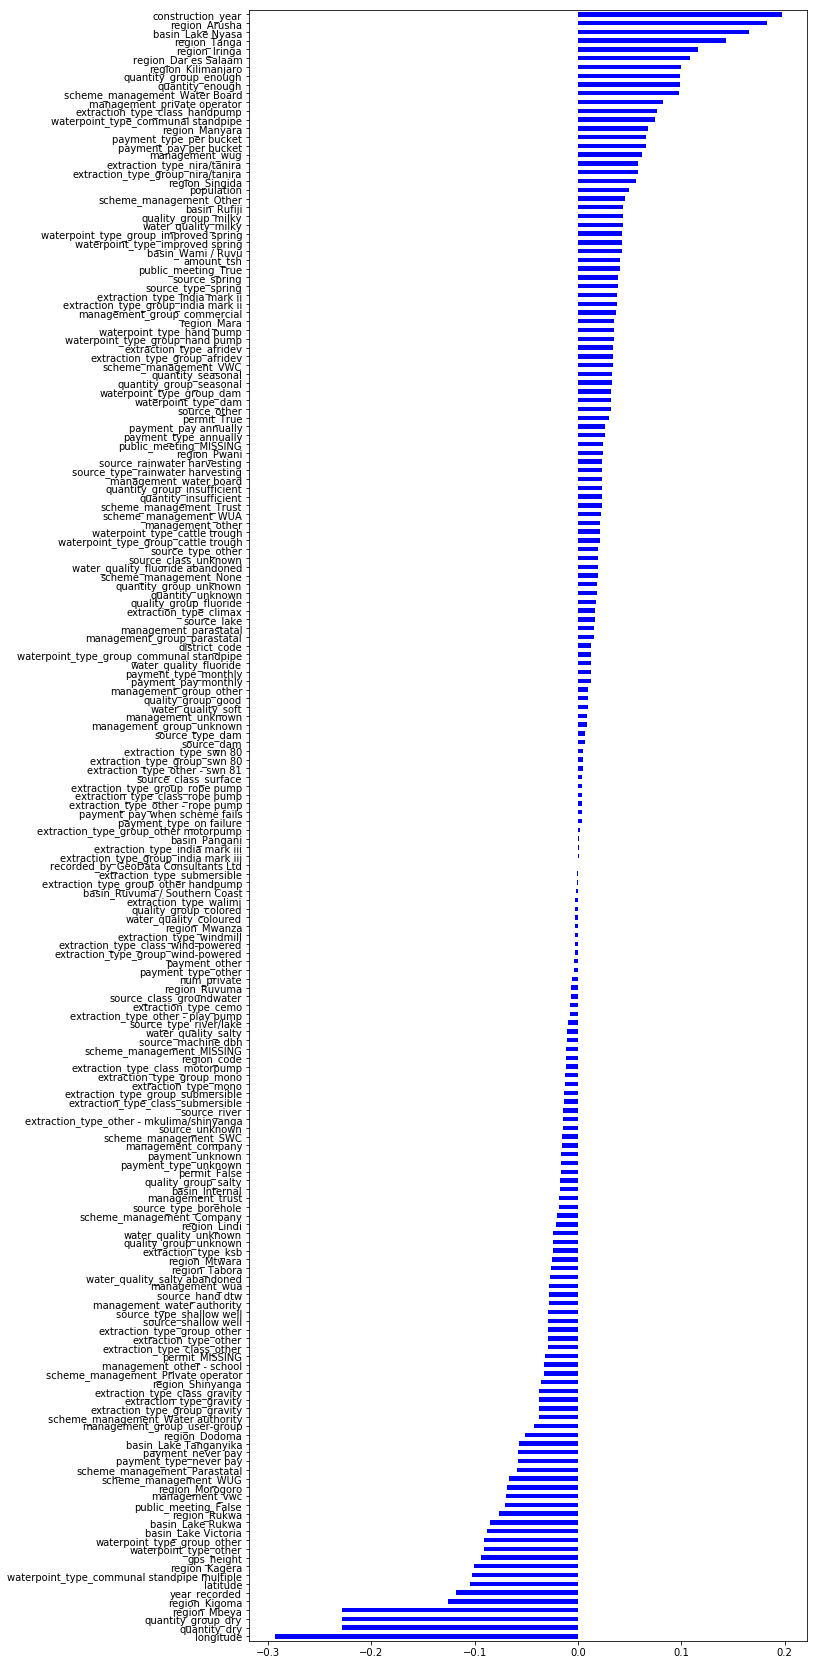

In [10]:
coefficients = pd.Series(model.coef_[0], x_train_encoded.columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='blue');

In [0]:
train_location = x_train[['longitude', 'latitude']].copy()
val_location = x_val[['longitude', 'latitude']].copy()

In [12]:
from sklearn.tree import DecisionTreeClassifier

max_dtc_depth = 10

dtc = DecisionTreeClassifier(max_depth = max_dtc_depth, random_state=42)
dtc.fit(train_location, y_train)

print('Decision Tree Model w/ Max Depth of', max_dtc_depth)
print('Train Accuracy:', dtc.score(train_location, y_train))
print('Val Accuracy:', dtc.score(val_location, y_val))

Decision Tree Model w/ Max Depth of 10
Train Accuracy: 0.6566498316498316
Val Accuracy: 0.6264309764309764


# **Module 2, Random Forest**

In [13]:
!pip install category_encoders
!pip install graphviz

In [0]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier as dtc

In [20]:
#pipeline
pipeline = make_pipeline(
  ce.OneHotEncoder(use_cat_names=True),
  SimpleImputer(strategy='median'),
  dtc(max_depth=20, random_state=42))

#fit, score, predict
pipeline.fit(x_train, y_train)
print('Validation Accuracy', pipeline.score(x_val, y_val))
y_pred = pipeline.predict(x_test)

#csv
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Anika-submission-2.csv', index=False)

files.download('Anika-submission-2.csv') 

Validation Accuracy 0.773063973063973


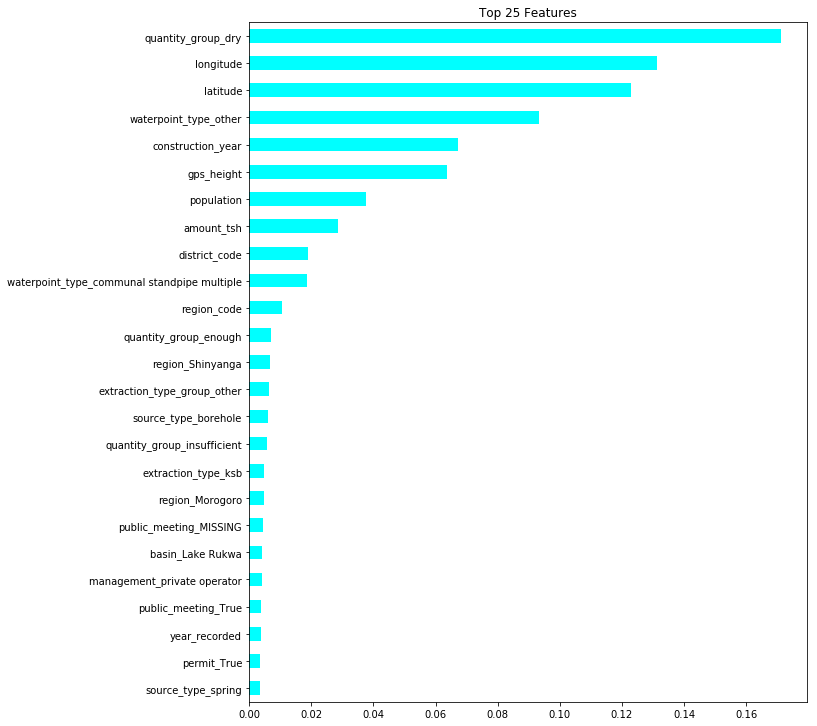

In [23]:
#feature importances
encoder = pipeline.named_steps['onehotencoder']
tree = pipeline.named_steps['decisiontreeclassifier']
feature_names = encoder.transform(x_val).columns
importances = pd.Series(tree.feature_importances_, feature_names)

#plot them
n=25
plt.figure(figsize=(10, n/2))
plt.title('Top 25 Features')
importances.sort_values()[-n:].plot.barh(color='cyan');

In [28]:
#random forest

from sklearn.ensemble import RandomForestClassifier as rtc

pipeline = make_pipeline(
  ce.OrdinalEncoder(),
  SimpleImputer(strategy='mean'),
  rtc(n_estimators=100, random_state=42, n_jobs=-1))

pipeline.fit(x_train, y_train)
print('Validation Accuracy', pipeline.score(x_val, y_val))
y_pred = pipeline.predict(x_test)

#csv
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Anika-submission-3.csv', index=False)

files.download('Anika-submission-3.csv') 

Validation Accuracy 0.8053872053872054
